# Extracting the transition probabilities and costs from the model

In [57]:
import util as ut

In [58]:
mdp = ut.get_file("2_mdps.pickle")
print(f"File contains info for {len(mdp)} MDPs.")

File contains info for 2 MDPs.


In [59]:
flight_index = 0
costs = mdp[flight_index][1][1]
actions = mdp[flight_index][1][3]
probabilities = mdp[flight_index][1][5]

In [61]:
# time horizon
T = len(costs)
print(f"Time horizon: {T}")

Time horizon: 24


Find maximum number of neighbors to determine size of action space:

In [62]:
max_num_neighbors = 0
for t in range(T):
    list_lengths = [len(lst) for lst in actions[t].values()]
    max_num_neighbors = max(max_num_neighbors, max(list_lengths))
print(f"Max number of neighbors: {max_num_neighbors}")
numActions = max_num_neighbors

Max number of neighbors: 75


Compute set of states (all visible neighbors for all timesteps, with duplicates removed). Then map set (with missing values) to range 0 to n-1, in order to reduce matrix size

(my) naming convention: state ID refers to the numbering in the model, state index refers to the numbering in the matrix (i.e. refers to visible states over all timesteps for one given flight)

In [63]:
# Find all visible states for all time steps
states = set(key for state_at_time in actions for key in state_at_time.keys())
s2i = {value: index for index, value in enumerate(states)} # state id to index
i2s = {index: value for index, value in enumerate(states)} # index to state id
numStates = len(states)
print(f"Number of actual states: {numStates}")
print(f"Number of states in infinite horizon MDP (S*T): {numStates*T}")

Number of actual states: 10867
Number of states in infinite horizon MDP (S*T): 260808


Data set checks

In [64]:
# Check data set consistency: every (state, action) pair has #transitions == #neighbors == #actions
for t in range(T):
    visible_states = actions[t].keys()
    for state in visible_states:
        #print(f"({t}, {state}):      {actions[t][state]}")
        n = len(actions[t][state])
        for action in range(n):
            assert len(probabilities[t][(state, action)]) == n

In [65]:
# Check that all probabilities sum to 1
for t in range(T):
    visible_states = actions[t].keys()
    for state in visible_states:
        n = len(actions[t][state])
        for action in range(n):
            assert abs(sum(probabilities[t][(state, action)]) - 1) < 1e-6

usage example:

In [66]:
# row of transition matrix for state id 13558 action 0, time 0
print(probabilities[0][(13558, 11)])

# neighbors of state 13558
print(actions[0][13558])

# example insertion into non-flattened transition probability tensor
for i in range(len(actions[0][13558])):
    if probabilities[0][(13558, 0)][i] > 0: # don't insert 0 probabilities (not necessary in a sparse matrix)
        print(f"insert {probabilities[0][(13558, 0)][i]} at col index {s2i[actions[0][13558][i]]}")

[0, 0, 0, 0.050000000000000044, 0, 0, 0, 0, 0, 0, 0, 0.95, 0]
[11522, 11524, 15241, 13558, 11523, 15240, 10, 14, 13547, 13546, 13548, 12, 15242]
insert 0.95 at col index 8362
insert 0.050000000000000044 at col index 9704


In [67]:
id2name = ut.get_file("num2node_dict.pickle")
name2id = ut.get_file("node2num_dict.pickle")

In [68]:
print(probabilities[23][(5413, 0)]) # TIPIK 50
print(actions[23][5413])
print(id2name[14454])
len(costs)
print(probabilities[17][(5370,1)])

[0.95, 0.050000000000000044, 0, 0, 0, 0, 0]
[14454, 5413, 14456, 5369, 5368, 14455, 5370]
MUS01_0
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


#### Mappings for transition probabilities and stage costs

Transition probabilitiy tensor $\mathcal{P} \in [0,1]^{\mathcal{T}\times\mathcal{S}\times\mathcal{A}\times\mathcal{T}\times\mathcal{S}}$ must be flattened into a 2D matrix by combining time, start state and actions into one index for the rows. Similarly for the cols, where time and start state are combined into one index.

Since the flattened transition probability matrix $P \in [0,1]^{\mathcal{TSA}\times\mathcal{TS}}$ has the same number of columns as the stage cost matrix $g \in \mathbb{R}^{\mathcal{TS}\times\mathcal{A}}$, the same mapping can be used for both.

In [69]:
# Mappping for flattened transition probability tensor (uses state index instead of state id!)
def global_row_P(time, state, action):
    return time * numStates * numActions + state * numActions + action

def inv_global_row_P(index):
    time = index // (numStates * numActions)
    state = (index % (numStates * numActions)) // numActions
    action = index % numActions
    return time, state, action

# Col mappings for flattened transition probability tensor (also row mapping for stage cost matrix)
def global_col_P(time, state):
    return time * numStates + state

def inv_global_col_P(index):
    time = index // numStates
    state = index % numStates
    return time, state

Create scipy transition probability matrix. Rows corresponding to infeasible actions are empty.

In [70]:
import numpy as np
import scipy.sparse as sp

# Prepare lists for row indices, column indices and values
rows = []
cols = []
values = []

# shape of P (incl. absorbing state)
ROWS = T * numStates * numActions + 1 * numActions
COLS = T * numStates + 1 


# fill in values
for t in range(T-1):
    visible_states = actions[t].keys()
    for s in visible_states:
        neighbors_ts = actions[t][s]
        numActions_ts = len(neighbors_ts)
        for a in range(numActions_ts):
            row = global_row_P(t, s2i[s], a)
            probs_tsa = probabilities[t][(s, a)]
            # filter out 0 probabilities
            vals = [p for p, c in zip(probs_tsa, neighbors_ts) if p > 0]
            col_indices = [global_col_P(t+1, s2i[c]) for p, c in zip(probs_tsa, neighbors_ts) if p > 0]

            # We add the row index to 'rows' as many times as there are values for that row
            rows.extend([row] * len(vals))
            cols.extend(col_indices)
            values.extend(vals)

# absorbing state: 
start_row = global_row_P(T-1, 0, 0)
rows.extend([i for i in range(start_row, start_row + (numStates+1)*numActions)])
cols.extend([T*numStates] * ((numStates+1)*numActions))
values.extend([1] * ((numStates+1)*numActions))




# Create COO matrix
P_coo = sp.coo_matrix((values, (rows, cols)), dtype=np.float64, shape=(ROWS, COLS))
print(P_coo.shape)
# Convert to CSR format
transitionProbabilityTensor = P_coo.tocsr()
print(transitionProbabilityTensor.shape)


(19560675, 260809)
(19560675, 260809)


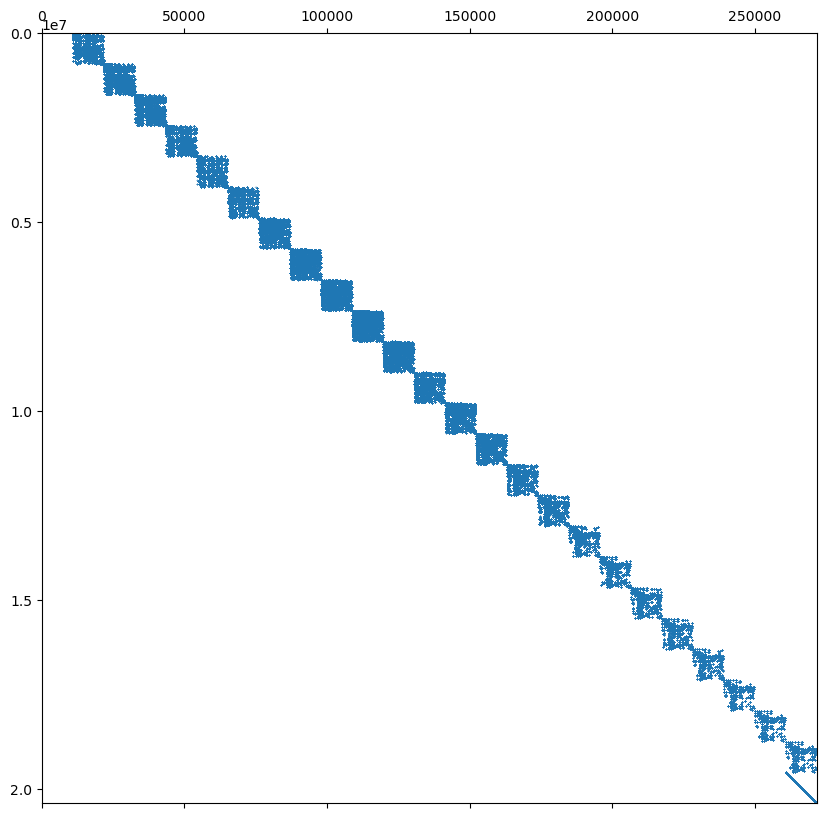

In [78]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
ax.spy(transitionProbabilityTensor, markersize=0.1)
ax.set_aspect('auto') # image is now square even though matrix is not!! Remove this line for original aspect ratio
plt.show()

Generate stage cost matrix, set costs for infeasible actions to infinity

In [77]:
# approach with (numStates+1) states
import numpy as np
import scipy.sparse as sp

# Prepare lists for row indices, column indices and values
rows = []
cols = []
values = []

# shape of P (incl. absorbing state)
ROWS = (T+1) * numStates * numActions
COLS = (T+1) * numStates 


# fill in values
for t in range(T+1):
    if t == T: # absorbing state
        for s in range(numStates):
            for a in range(numActions):
                row = global_row_P(t, s, a)
                col = global_col_P(t, s)
                rows.append(row)
                cols.append(col)
                values.append(1)
    else:
        visible_states = actions[t].keys()
        for s in visible_states:
            neighbors_ts = actions[t][s]
            numActions_ts = len(neighbors_ts)
            for a in range(numActions_ts):
                row = global_row_P(t, s2i[s], a)
                probs_tsa = probabilities[t][(s, a)]
                # filter out 0 probabilities
                vals = [p for p, c in zip(probs_tsa, neighbors_ts) if p > 0]
                col_indices = [global_col_P(t+1, s2i[c]) for p, c in zip(probs_tsa, neighbors_ts) if p > 0]

                # We add the row index to 'rows' as many times as there are values for that row
                rows.extend([row] * len(vals))
                cols.extend(col_indices)
                values.extend(vals)



# Create COO matrix
P_coo = sp.coo_matrix((values, (rows, cols)), dtype=np.float64, shape=(ROWS, COLS))
print(P_coo.shape)
# Convert to CSR format
transitionProbabilityTensor = P_coo.tocsr()
print(transitionProbabilityTensor.shape)

(20375625, 271675)
(20375625, 271675)


In [72]:
# stage cost matrix (T * numStates x numActions)

inf = 1e10

rows = []
cols = []
values = []

g_ROWS = T * numStates + 1
g_COLS = numActions

for t in range(T):
    visible_states = actions[t].keys()
    for s in range(numStates):
        if i2s[s] in visible_states:
            row = global_col_P(t, s)
            for a in range(numActions): # need to iterate over all actions, not just neighbors_ts!
                rows.append(row)
                cols.append(a)
                values.append(costs[t].get((i2s[s], a), inf)) # cost is inf if action is not feasible
    
        else: # fill row with inf
            row = global_col_P(t, s)
            for a in range(numActions):
                rows.append(row)
                cols.append(a)
                values.append(inf)

# absorbing state
rows.extend([T*numStates] * numActions)
cols.extend([i for i in range(numActions)])
values.extend([0] * numActions)

g_coo = sp.coo_matrix((values, (rows, cols)), dtype=np.float64, shape=(g_ROWS, g_COLS))
print(g_coo.shape)
stageCostMatrix = g_coo.tocsr()
print(stageCostMatrix.shape)

(260809, 75)
(260809, 75)


In [79]:
# stage cost matrix (T * numStates x numActions)

inf = 1e10

rows = []
cols = []
values = []

g_ROWS = (T+1) * numStates
g_COLS = numActions

for t in range(T+1):
    if t == T: # absorbing state (cost 0)
        for s in range(numStates):
            row = global_col_P(t, s)
            for a in range(numActions):
                rows.append(row)
                cols.append(a)
                values.append(0)
    else:
        visible_states = actions[t].keys()
        for s in range(numStates):
            if i2s[s] in visible_states:
                row = global_col_P(t, s)
                for a in range(numActions): # need to iterate over all actions, not just neighbors_ts!
                    rows.append(row)
                    cols.append(a)
                    values.append(costs[t].get((i2s[s], a), inf)) # cost is inf if action is not feasible
        
            else: # fill row with inf
                row = global_col_P(t, s)
                for a in range(numActions):
                    rows.append(row)
                    cols.append(a)
                    values.append(inf)

g_coo = sp.coo_matrix((values, (rows, cols)), dtype=np.float64, shape=(g_ROWS, g_COLS))
print(g_coo.shape)
stageCostMatrix = g_coo.tocsr()
print(stageCostMatrix.shape)

(271675, 75)
(271675, 75)


In [15]:
# print last row of stage cost matrix
print(actions[T-1].keys())
print(s2i[5413])
print(stageCostMatrix[(T-1)*numStates + s2i[5413]])

dict_keys([5413, 5368, 5369, 5370, 14454, 14455, 14456, 4224, 4225, 5379, 5380, 5390, 5391, 5401, 5402, 3565, 3566, 5412, 4379, 4380, 5423, 5424, 3675, 3676, 5434, 5435, 4226, 5381, 5392, 5403, 3568, 5414, 4382, 5425, 3678, 5436, 4227, 5382, 5393, 5404, 3570, 5415, 4384, 5426, 3680, 5437, 8888, 8889, 12463, 12464, 8890, 12465, 8891, 12466, 4180, 4183, 10681, 10682, 10692, 10693, 4185, 10683, 10694, 12430, 12431, 12441, 12442, 12452, 12453, 12432, 12443, 12454, 8877, 8878, 8879, 3564, 3567, 11496, 11497, 3569, 11499, 4378, 4381, 89, 90, 7107, 7108, 8305, 8306, 4383, 92, 7110, 8307, 7810, 7811, 3597, 3598, 7812, 3599, 3674, 3677, 3679, 11495, 11498, 11500, 4187, 5371, 10684, 10695, 12433, 12444, 12455, 8880, 3571, 11501, 14457, 4385, 94, 7112, 8308, 7813, 3600, 3681, 11502, 4189, 5372, 10685, 5405, 10696, 4386, 12434, 8892, 12445, 12456, 8881, 4228, 3682, 3573, 11503, 14458, 4387, 96, 5383, 7114, 8309, 7814, 3601, 3683, 11504, 4202, 4203, 4204, 2068, 2069, 2070, 4205, 2071, 5394, 4206, 2

Save transition probabilities and stage costs in PETSc binary format

In [85]:
from save_matrix import *
import os

# write transition probability tensor
if not os.path.exists("data"):
    os.makedirs("data")

path_P = os.path.join("data", f"{flight_index}_P_NEW.bin")
path_g = os.path.join("data", f"{flight_index}_g_NEW.bin")

#writeBinarySparseMatrix(transitionProbabilityTensor, path_P)
#writeBinaryDenseMatrix(stageCostMatrix, path_g)

# Run inexact Policy Iteration

In [86]:
flags = [
    "-mat_type", "mpiaij",
    "-pc_type", "none",
    "-ksp_type", "gmres",
    "-mode", "MINCOST",
    "-maxIter_PI", str(30),
    "-maxIter_KSP", str(1000),
    "-numPIRuns", str(1),
    "-rtol_KSP", str(1e-4),
    "-atol_PI", str(1e-10),
    "-states", str(numStates*T+1),
    "-actions", str(numActions),
    "-discountFactor", str(0.99),
    "-file_P", path_P,
    "-file_g", path_g,
    "-file_stats", os.path.join("out", f"{flight_index}_stats_NEW.json"),
    "-file_policy", os.path.join("out", f"{flight_index}_policy_NEW.out"),
    "-file_cost", os.path.join("out", f"{flight_index}_cost_NEW.out")
]

if not os.path.exists("out"):
    os.makedirs("out")

executable = "distributed_inexact_policy_iteration"
executable_path = os.path.join("..", "build", executable)

cpus = 1
#cmd = ["mpirun", "-n", str(cpus), "--report-bindings", executable_path, *flags]
cmd = [executable_path, *flags]
print(" ".join(cmd))


../build/distributed_inexact_policy_iteration -mat_type mpiaij -pc_type none -ksp_type gmres -mode MINCOST -maxIter_PI 30 -maxIter_KSP 1000 -numPIRuns 1 -rtol_KSP 0.0001 -atol_PI 1e-10 -states 260809 -actions 75 -discountFactor 0.99 -file_P data/0_P_NEW.bin -file_g data/0_g_NEW.bin -file_stats out/0_stats_NEW.json -file_policy out/0_policy_NEW.out -file_cost out/0_cost_NEW.out


In [87]:
import subprocess
subprocess.run(cmd)

[R0]   setValuesFromOptions  owns 260809 states.
[R0]   loadFromBinaryFile  Loading MDP from binary file: data/0_P_NEW.bin, data/0_g_NEW.bin
[R0]   loadFromBinaryFile  owns rows 0 to 19560675 of P.
[R0]   loadFromBinaryFile  owns rows 0 to 260809 of g.
MDP setup + loading took: 4140 ms
[R0]   inexactPolicyIteration  Entering inexactPolicyIteration
[R0]   inexactPolicyIteration  Iteration 0 residual norm: 9999999999.990000
[R0]   inexactPolicyIteration  Iteration 1 residual norm: 28.700100
[R0]   inexactPolicyIteration  Iteration 2 residual norm: 34.137618
[R0]   inexactPolicyIteration  Iteration 3 residual norm: 24.800500
[R0]   inexactPolicyIteration  Iteration 4 residual norm: 12.697177
[R0]   inexactPolicyIteration  Iteration 5 residual norm: 5.861296
[R0]   inexactPolicyIteration  Iteration 6 residual norm: 5.665156
[R0]   inexactPolicyIteration  Iteration 7 residual norm: 2.695505
[R0]   inexactPolicyIteration  Iteration 8 residual norm: 0.886385
[R0]   inexactPolicyIteration  Ite

CompletedProcess(args=['../build/distributed_inexact_policy_iteration', '-mat_type', 'mpiaij', '-pc_type', 'none', '-ksp_type', 'gmres', '-mode', 'MINCOST', '-maxIter_PI', '30', '-maxIter_KSP', '1000', '-numPIRuns', '1', '-rtol_KSP', '0.0001', '-atol_PI', '1e-10', '-states', '260809', '-actions', '75', '-discountFactor', '0.99', '-file_P', 'data/0_P_NEW.bin', '-file_g', 'data/0_g_NEW.bin', '-file_stats', 'out/0_stats_NEW.json', '-file_policy', 'out/0_policy_NEW.out', '-file_cost', 'out/0_cost_NEW.out'], returncode=0)